### Mean-Variance Potfolio Optimization with Elastic Net Penalty


In [1]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize
from qpsolvers import solve_qp
from scipy.sparse import csc_matrix, csc_array
import matplotlib.pyplot as plt

###  Returns below
- Note log returns have caused some issues numerically within optimiztion

In [330]:
equity_data=pd.read_csv('equity_data_2021.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=((equity_data/equity_data.shift(1))-1)
returns=returns.fillna(0)
returns=returns.iloc[1:]
frac=0.75
cutoff=np.floor(frac*len(returns.index)).astype(int)

returns_train=returns.iloc[:cutoff]
returns_test=returns.iloc[cutoff:]

returns_train

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.000042,0.006013,0.002211,0.015649,0.017300,0.004615,0.015550,-0.007733,0.018796,0.010863,...,0.018709,-0.006279,-0.010834,-0.006693,0.012193,-0.000858,0.019863,0.006932,-0.001183,0.004598
2018-01-04,0.013071,0.004685,-0.001697,-0.005703,0.017516,0.011841,-0.009952,0.016843,0.012042,0.009552,...,0.010151,0.007813,0.005415,-0.007791,0.006676,0.010180,0.019760,-0.001441,0.004147,0.005964
2018-01-05,0.007792,0.012864,0.002890,0.017408,0.015408,0.008249,0.026446,-0.006675,0.011571,-0.000591,...,0.006413,0.009277,0.006671,-0.007003,-0.001874,0.005828,0.015576,0.009941,0.000393,0.011444
2018-01-08,-0.003242,0.004763,-0.002882,-0.016022,0.027086,0.007991,0.003917,-0.002240,-0.001619,-0.003043,...,-0.005387,0.000000,-0.013314,0.007480,0.003611,0.001690,0.009951,0.001905,-0.004914,0.011996
2018-01-09,0.006214,-0.000790,0.001700,0.007538,0.009432,0.003335,-0.006604,0.003243,0.008971,0.006953,...,0.002774,-0.004029,0.006778,-0.011667,0.000288,-0.002651,0.030643,-0.016083,0.023509,0.011719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.003046,0.006714,0.008376,-0.000194,-0.002105,-0.000544,0.008314,0.001824,0.005937,0.007820,...,0.014319,0.011956,-0.007892,0.004976,0.005214,0.007023,-0.007505,0.001812,-0.003907,0.005443
2020-12-28,0.001089,0.002523,-0.005168,0.001840,0.031311,0.009250,0.005167,0.005259,-0.001820,0.000283,...,-0.018271,-0.003056,0.009441,0.010676,0.001197,0.020829,0.015124,-0.002412,0.000461,0.010391
2020-12-29,-0.004922,-0.016361,0.005010,0.012083,0.025630,-0.007394,-0.000656,-0.005030,0.006333,-0.009852,...,-0.000721,-0.016944,-0.010046,0.001531,-0.008568,-0.003006,-0.011893,0.023910,-0.013607,0.004495


### Computation of Naive mean and covariance estimation from sample

In [331]:
returns_mean=returns_train.mean().values
returns_cov=np.cov(returns_train.T)

Text(0, 0.5, 'Freq')

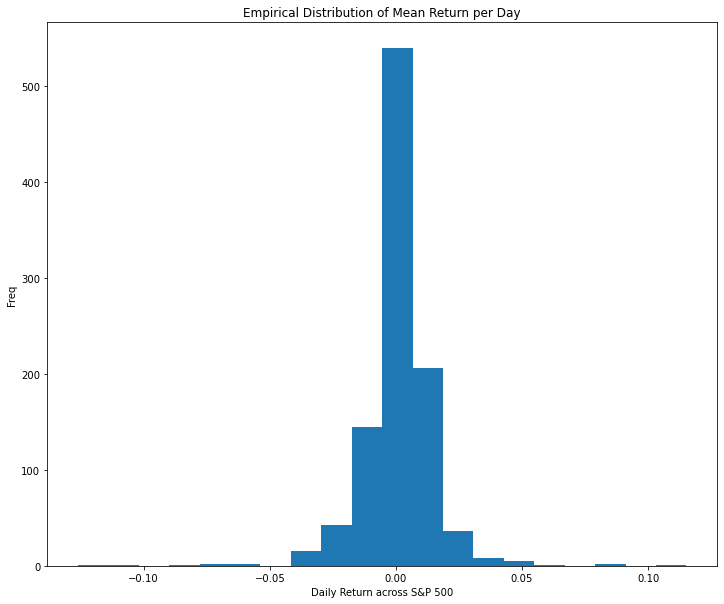

In [332]:
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.hist(returns.mean(axis=1),bins=20)
plt.title("Empirical Distribution of Mean Return per Day")
plt.xlabel("Daily Return across S&P 500")
plt.ylabel("Freq")

Text(0.5, 1.0, 'Singular Values of Covariance Matrix')

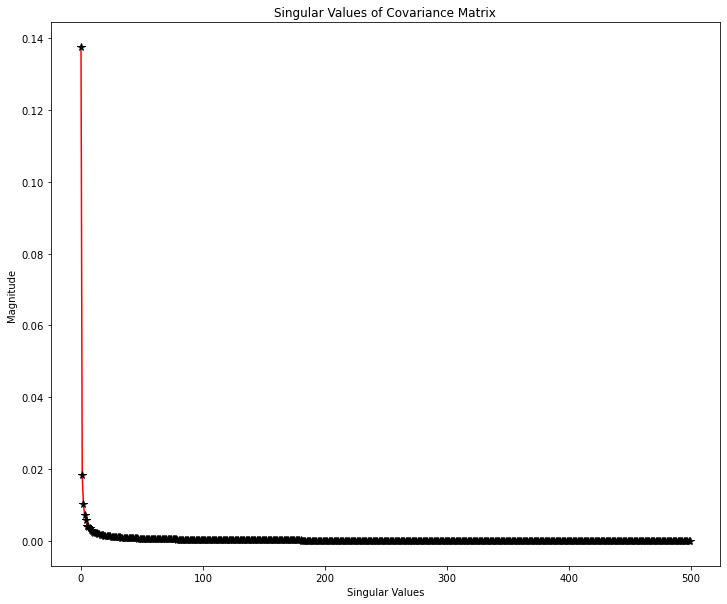

In [333]:
u,s,v=np.linalg.svd(returns_cov)
fig,ax=plt.subplots(figsize=(12,10))
bins=plt.plot(s,marker='*',color='red',markersize=7.5,mfc='black',mec='black')
plt.xlabel('Singular Values')
plt.ylabel('Magnitude')
plt.title("Singular Values of Covariance Matrix")

### Regularized Covariance and Mean Estimators

### Application of Sparse Solver Split Bregman Operator

Utilizes nested optimization routine where
- Inner Optimization is unconstrained QP problem involving L2 penalty
    - Can solve numerically via unconstrained minimization
    - Solve analytically via QPSolvers
- Applies shrinkage (L1) penalty within outer loop


In [334]:
def qp(cov,mean,w,d,b,beta,lambda1,tol,maxiter,approach):
    """ Inner optimization problem using unconstrained optimization 
        Approach 1 solves numerically via unconstrained minimization
        Approach 2 solves analytically via qpsolvers 
    """
    
    x0=w # initial guess is previous result
    
    if approach==1:
        # Numerical soln is much slower as unconstrained minimization
        def objective_val(w,cov,mean,d,b,beta,lambda1):
            """ MPT objective
            """

            obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)

            l2_pen=np.sum((d-beta*w-b)**2)

            return obj+lambda1*l2_pen/2

        res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':25},tol=1e-12)
        w=res.x
        
    if approach==2:
        # analytical soln is very fast
        sparse_cov=csc_matrix(2*(cov+2*lambda1*np.identity(len(w))))
        mean=-1*mean
        w = solve_qp(sparse_cov,mean,initvals=x0, solver="osqp")
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,beta=None,tol=1e-10,maxiter=100,approach=2):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%25==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1,tol,maxiter,approach)
        error=np.sum((w-w_old)**2)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    
    
    print(f"Terminated in {i} iterations of error {error}")
    unit_w=w/np.linalg.norm(w,ord=1)
    return unit_w, error



### Numerical Results

- 10x magnitude on lambda1 param

In [335]:
lambda1=10e-4

w0,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 2.6671716466680825e-11


Text(0, 0.5, 'Weight Allocation')

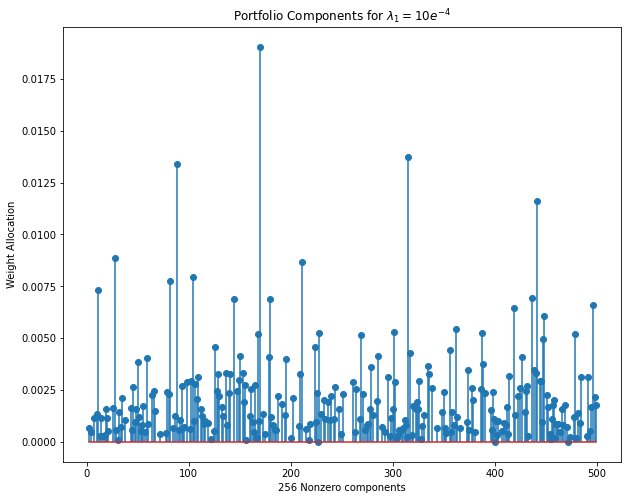

In [347]:
nonzero_w0=np.where(w0>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-4}$")
ax.stem(nonzero_w0,w0[nonzero_w0])
plt.xlabel(f"{len(nonzero_w0)} Nonzero components")
plt.ylabel("Weight Allocation")

In [337]:
lambda1=10e-2
w1,error1=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 2 iterations of error 1.6718699928072206e-14


Text(0, 0.5, 'Weight Allocation')

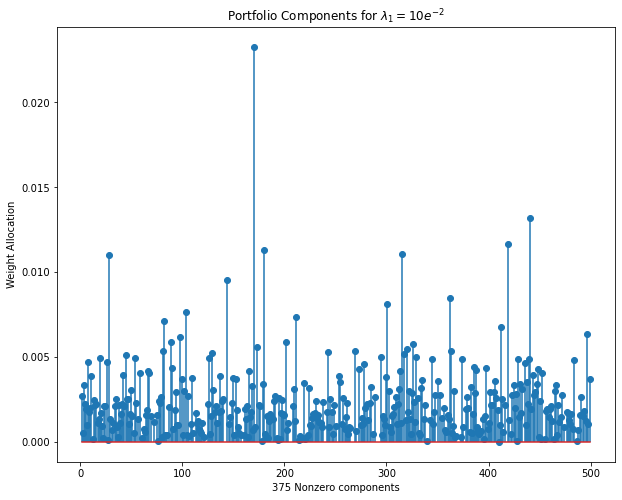

In [348]:
nonzero_w1=np.where(w1>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^{-2}$")
ax.stem(nonzero_w1,w1[nonzero_w1])
plt.xlabel(f"{len(nonzero_w1)} Nonzero components")
plt.ylabel("Weight Allocation")

In [339]:
lambda1=10e2
w2,error2=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 1 iterations of error 2.874022771103261e-11


Text(0, 0.5, 'Weight Allocation')

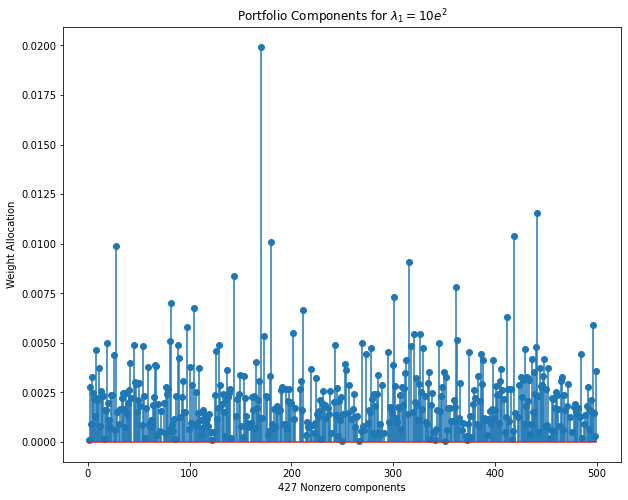

In [349]:
nonzero_w2=np.where(w2>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^2$")
ax.stem(nonzero_w2,w2[nonzero_w2])
plt.xlabel(f"{len(nonzero_w2)} Nonzero components")
plt.ylabel("Weight Allocation")


In [341]:
lambda1=10e4
w3,error3=split_bregman(returns_cov,returns_mean,lambda1=lambda1,tol=1e-8,maxiter=25,approach=2)

Terminated in 1 iterations of error 2.8741744538910394e-15


Text(0, 0.5, 'Weight Allocation')

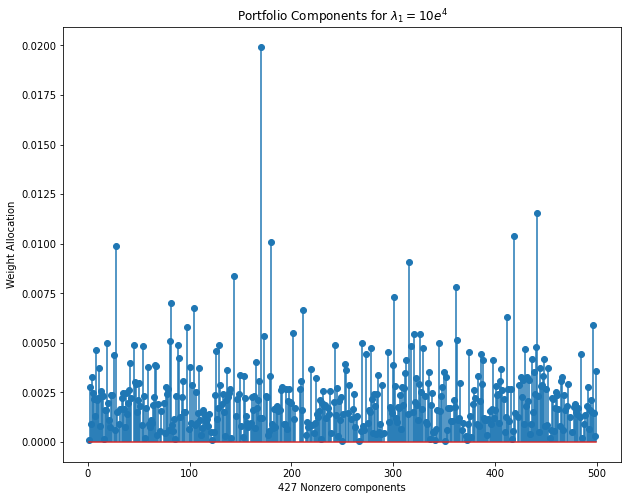

In [350]:
nonzero_w3=np.where(w3>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=10e^4$")
ax.stem(nonzero_w3,w3[nonzero_w3])
plt.xlabel(f"{len(nonzero_w3)} Nonzero components")
plt.ylabel("Weight Allocation")

### Grid Search Lambda Values 

In [362]:
def grid_search(params,returns_mean,returns_cov,tol=1e-8,maxiter=25):
    results={}
    for i in params:
        w,error=split_bregman(returns_cov,returns_mean,lambda1=i,tol=1e-8,maxiter=25,approach=2)
        results[i]=(w,error)
    sorted_dict=sorted(results.items(), key=lambda x:x[1][1])
    return sorted_dict

lambda_grid=np.logspace(-4,4,8)

sorted_dict=grid_search(lambda_grid,returns_mean,returns_cov)

Terminated in 2 iterations of error 6.882522357085543e-10
Terminated in 2 iterations of error 1.644462953566252e-11
Terminated in 2 iterations of error 2.8696856006217703e-13
Terminated in 2 iterations of error 2.7492357511756596e-15
Terminated in 2 iterations of error 1.6483749712148466e-17
Terminated in 2 iterations of error 8.649681369527831e-20
Terminated in 1 iterations of error 5.5487540341293127e-11
Terminated in 1 iterations of error 2.8741606634114055e-13


Text(0, 0.5, 'Weight Allocation')

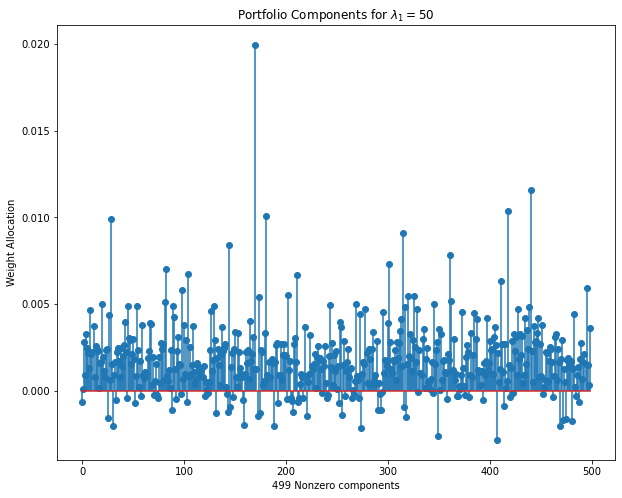

In [365]:
wi=sorted_dict[0][1][0]
nonzero_wi=np.where(abs(wi)>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components for $\lambda_1=50$")
ax.stem(wi[nonzero_wi])
plt.xlabel(f"{len(wi[nonzero_wi])} Nonzero components")
plt.ylabel("Weight Allocation")

In [358]:
print(f"Largest Component is {max(wi[nonzero_wi])}")
print(f"Smallest Component is {min(wi[nonzero_wi])}")

Largest Component is 0.019951048991841216
Smallest Component is -0.0028493700115689736


### Sharpe Ratio Performance 

In [346]:
returns_test

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-04,-0.016706,-0.016417,-0.003471,-0.016239,-0.023041,-0.018185,-0.031772,-0.010712,-0.029553,-0.041090,...,-0.033131,-0.035803,-0.052557,-0.015149,-0.020631,-0.025239,-0.016132,-0.006035,-0.011740,-0.011541
2021-01-05,-0.001687,0.006491,0.012373,0.010341,0.018533,0.005693,0.008788,0.019451,0.000721,-0.002782,...,-0.008346,0.002895,0.030776,-0.009747,-0.001204,0.000095,0.006453,0.017302,0.015840,0.006969
2021-01-06,0.015212,0.034457,-0.002082,-0.008638,-0.003069,0.010934,-0.029662,0.040519,-0.039902,-0.003502,...,0.008416,0.005850,0.005990,0.022147,0.042181,0.005481,0.037444,0.028496,0.112359,0.014691
2021-01-07,-0.025662,0.012291,0.009707,0.010703,0.006063,0.009435,0.018977,-0.008885,0.024512,0.005658,...,0.007609,0.007151,-0.009923,-0.019561,0.045389,-0.007612,0.036168,-0.005928,0.030509,-0.000897
2021-01-08,-0.018265,-0.011790,0.002785,0.005248,0.001545,0.003647,0.018178,0.002670,0.015406,0.013029,...,-0.007844,-0.008325,-0.006560,0.009208,-0.010140,0.014678,-0.008873,-0.002197,-0.025405,0.006647
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,0.009887,0.023318,0.016528,0.009918,0.015956,0.029803,0.004450,0.009627,0.014150,0.017727,...,0.010995,0.026123,-0.014626,0.003153,0.006723,0.019728,0.041071,0.006457,0.010423,0.016494
2021-12-28,0.005320,0.009917,-0.006998,-0.000149,-0.001090,-0.000144,0.018640,0.013017,-0.014402,-0.000893,...,-0.001422,0.009145,-0.012788,0.011973,0.010398,-0.000217,-0.014860,0.003130,0.001587,-0.009168
2021-12-29,0.004335,0.003156,0.005126,0.007218,0.012310,0.000361,0.007350,0.001195,-0.000123,0.007884,...,-0.001215,0.008678,-0.017118,0.005028,-0.001339,0.004928,0.006362,0.000156,0.005387,0.011382
